In [42]:
import os
import pydicom as dicom
from tqdm import tqdm

In [28]:
def get_all_slices(path, list_files):
    file_slice = []
    skipcount = 0
    for arg in list_files:
        file_path = os.path.join(path, arg)
        ds = dicom.dcmread(file_path) #reading dicom file
        if hasattr(ds, 'InstanceNumber'):
            file_slice.append(ds) #appending the dicom object one we read it and has an InstanceNumber attribute
        else:
            skipcount += 1
    return (file_slice, skipcount)

In [29]:
def get_file_path(path):
    from os import listdir as ld    
    files = [file_path for file_path in ld(path)]
    print('Total Dicom Slices: {}'.format(len(files)))
    return files

In [32]:
path = "C:\\Users\\AnilYadav\\Desktop\\git_repo\\data\\113176\\113176"
file_lst = get_file_path(path) # adding ';' at the end of line will suppress printing

Total Dicom Slices: 116


In [33]:
slices = get_all_slices(path, file_lst)
slice_arr = slices[0]
skip_count = slices[1]

In [34]:
slice_arr = sorted(slice_arr, key=lambda x: x.InstanceNumber)

In [35]:
%matplotlib inline

import numpy as np 
import pandas as pd
import pydicom as dicom
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [36]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Original Slice


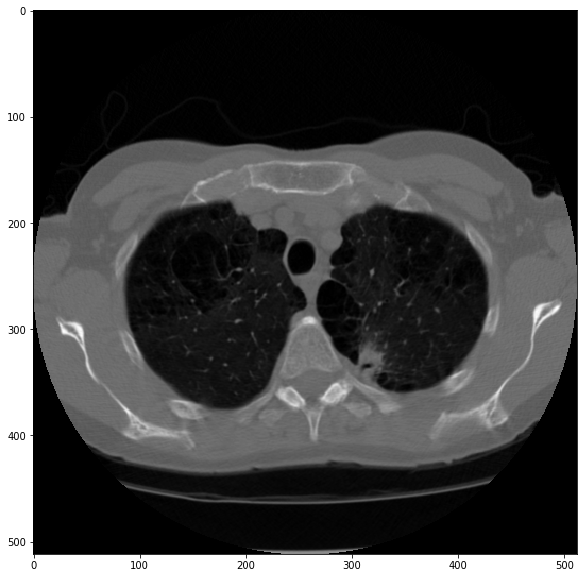

In [37]:
test_patient_images = get_pixels_hu(slice_arr)
plt.figure(figsize=(20,10))
print ("Original Slice")
plt.imshow(test_patient_images[22], cmap='gray')
plt.show()

Internal Marker


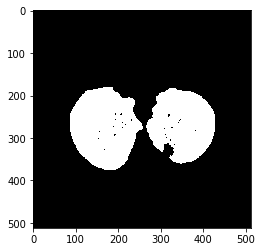

External Marker


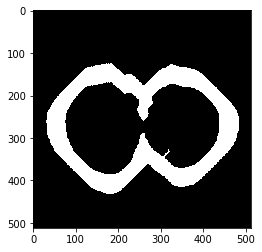

Watershed Marker


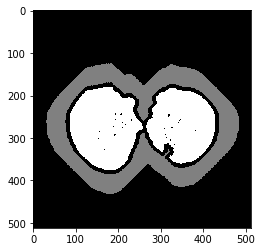

In [38]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed


# example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[22])

print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

Sobel Gradient


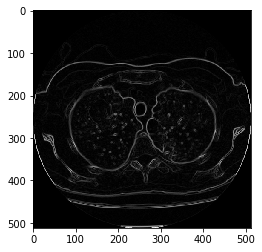

Watershed Image


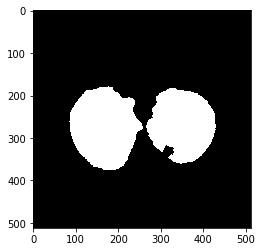

Outline after reinclusion


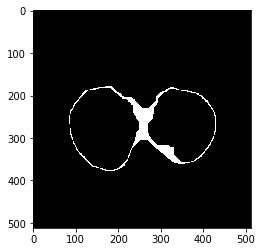

Lungfilter after closing


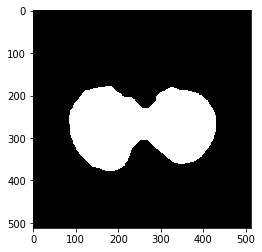

In [39]:
def seperate_lungs(image):
    
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed


#Testcode of one CT
test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(test_patient_images[22])

print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()

Segmented Lung


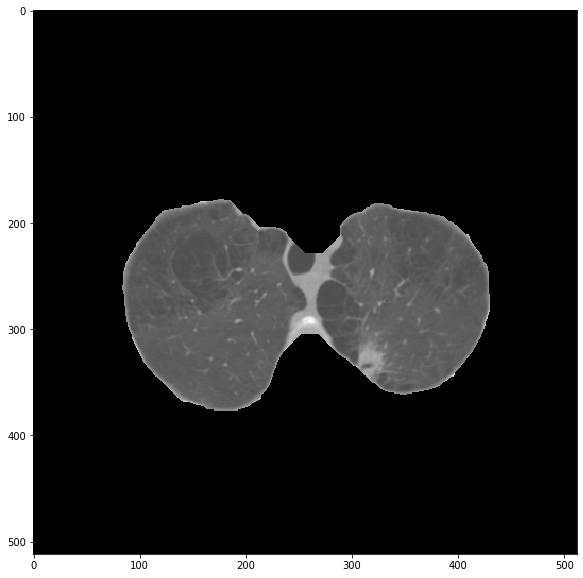

In [22]:
print ("Segmented Lung")
plt.figure(figsize=(20,10))
plt.imshow(test_segmented, cmap='gray')
plt.show()

### Run the segmentation on all CT slices for a patient

In [47]:
import imageio

for index, patient in tqdm(enumerate(test_patient_images)):
    path_to_jpg = 'C:\\Users\\AnilYadav\\Desktop\\git_repo\\lung_segmentation\\data\\png_113176\\slice_{}.png'.format(index)
    path_to_segment = 'C:\\Users\\AnilYadav\\Desktop\\git_repo\\lung_segmentation\\data\\segment_113176\\slice_{}.png'.format(index)
    imageio.imwrite(path_to_jpg, patient) #save arrays as jpeg file
    #extract maker and segment images
    test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(patient)
    imageio.imwrite(path_to_segment, test_segmented) #save the segmented file

0it [00:00, ?it/s]Lossy conversion from int16 to uint8. Range [-1024, 1730]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 1554.0]. Convert image to uint8 prior to saving to suppress this warning.
1it [00:02,  2.36s/it]Lossy conversion from int16 to uint8. Range [-1024, 1816]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 1518.0]. Convert image to uint8 prior to saving to suppress this warning.
2it [00:04,  2.37s/it]Lossy conversion from int16 to uint8. Range [-1024, 1860]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 263.0]. Convert image to uint8 prior to saving to suppress this warning.
3it [00:07,  2.37s/it]Lossy conversion from int16 to uint8. Range [-1024, 1772]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 t

30it [01:12,  2.40s/it]Lossy conversion from int16 to uint8. Range [-1024, 1575]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 953.0]. Convert image to uint8 prior to saving to suppress this warning.
31it [01:14,  2.40s/it]Lossy conversion from int16 to uint8. Range [-1024, 1610]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 939.0]. Convert image to uint8 prior to saving to suppress this warning.
32it [01:16,  2.41s/it]Lossy conversion from int16 to uint8. Range [-1024, 1594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 1057.0]. Convert image to uint8 prior to saving to suppress this warning.
33it [01:19,  2.41s/it]Lossy conversion from int16 to uint8. Range [-1024, 1578]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

60it [02:25,  2.44s/it]Lossy conversion from int16 to uint8. Range [-1024, 1312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 1206.0]. Convert image to uint8 prior to saving to suppress this warning.
61it [02:27,  2.43s/it]Lossy conversion from int16 to uint8. Range [-1024, 1418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 1316.0]. Convert image to uint8 prior to saving to suppress this warning.
62it [02:29,  2.44s/it]Lossy conversion from int16 to uint8. Range [-1024, 1338]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 1154.0]. Convert image to uint8 prior to saving to suppress this warning.
63it [02:32,  2.43s/it]Lossy conversion from int16 to uint8. Range [-1024, 1252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 

90it [03:37,  2.45s/it]Lossy conversion from int16 to uint8. Range [-1024, 1314]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 1235.0]. Convert image to uint8 prior to saving to suppress this warning.
91it [03:40,  2.44s/it]Lossy conversion from int16 to uint8. Range [-1024, 1311]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 1227.0]. Convert image to uint8 prior to saving to suppress this warning.
92it [03:42,  2.44s/it]Lossy conversion from int16 to uint8. Range [-1024, 1243]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2000.0, 1210.0]. Convert image to uint8 prior to saving to suppress this warning.
93it [03:45,  2.43s/it]Lossy conversion from int16 to uint8. Range [-1024, 1323]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from 